In [10]:
import pandas as pd

import fnmatch
import glob
import dropbox as db

from matplotlib import pyplot as plt
import seaborn as sns

In [63]:
!ln -s /Users/matthiashugli/Virtualenvs/youth-base/youth-base/config.py config.py
from config import dbx_token
dbx = db.Dropbox(dbx_token)

ligue1_bucket = '/Users/matthiashugli/Dropbox/bucket/ligue-1/*.csv'
bundesliga_bucket = '/Users/matthiashugli/Dropbox/bucket/bundesliga/*.csv'
pl_bucket = '/Users/matthiashugli/Dropbox/bucket/premier-league/*.csv'

sources = [ligue1_bucket, bundesliga_bucket, pl_bucket]

df = pd.DataFrame()
for path in sources:
    for filename in glob.glob(path):
        file = pd.read_csv(filename, header=0, delimiter=',', low_memory=False)
        file.insert(1, 'filename', filename)
        df = df.append(file)
    

ln: config.py: File exists


# Data Preparation

## Data Cleansing

In [64]:
df[['source', 'file']] = df.filename.apply(lambda x: pd.Series(str(x).split('raw-')))
df[['goalkeeper', 'year']] = df.file.apply(lambda x: pd.Series(str(x).split('-saison')))
df['goalkeeper'] = df.goalkeeper.map(lambda x: x[0].upper() + x[1:])
df[['season', 'type']] = df.year.apply(lambda x: pd.Series(str(x).split('.csv')))
df['goalkeeper'] = df.goalkeeper.replace('-.*$', '', regex=True)
df['season'] = df.season.replace('.csv', '', regex=True)

df.columns = df.columns.str.strip().str.lower().str.replace(' ','_')
df = df.drop(columns=['filename', 'source', 'file', 'year', 'type', 'match_report'])
df = df.dropna(how='all')
df = df.dropna(subset=['psxg'])

# Expected Saves Model

In [65]:
df['shots_faced'] = df['ga'] + df['saves'] + df['pksv']
df['psxs'] = df['shots_faced'] - df['psxg']

## Bundesliga

### Performance Season 2020 / 2021

   goalkeeper  saves   psxs  shots_faced  psxg    ga  pksv   sota  save_perc  \
0     Baumann   81.0   85.8        134.0  48.2  51.0   2.0  126.0   0.604478   
1      Bürki   63.0   67.7         93.0  25.3  30.0   0.0   89.0   0.677419   
2    Casteels   72.0   73.5        107.0  33.5  33.0   2.0  101.0   0.672897   
3   Fährmann   94.0  104.5        145.0  40.5  50.0   1.0  139.0   0.648276   
4   Gikiewicz  124.0  129.0        181.0  52.0  55.0   2.0  172.0   0.685083   
5     Gulacsi   48.0   53.4         78.0  24.6  30.0   0.0   77.0   0.615385   
6        Hitz   27.0   27.3         43.0  15.7  16.0   0.0   42.0   0.627907   
7        Horn   98.0  105.4        158.0  52.6  59.0   1.0  150.0   0.620253   
8    Hradecky   56.0   59.3         86.0  26.7  29.0   1.0   82.0   0.651163   
9       Kobel  105.0  112.3        161.0  48.7  54.0   2.0  155.0   0.652174   
10      Luthe   84.0   85.9        127.0  41.1  42.0   1.0  123.0   0.661417   
11    Müller  110.0  110.1        157.0

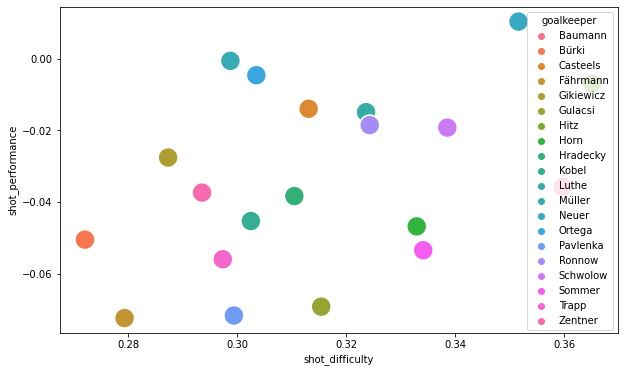

In [66]:
season = '20-21'
competition = 'Bundesliga'

bundesliga = df[(df.comp == competition) & (df.season == season)]

xs_bundesliga = bundesliga.groupby('goalkeeper').agg({'saves': 'sum', 'psxs': 'sum', 'shots_faced': 'sum', 'psxg': 'sum', 'ga': 'sum', 'pksv': 'sum', 'sota': 'sum'}).reset_index()
xs_bundesliga['save_perc'] = xs_bundesliga['saves'] / xs_bundesliga['shots_faced']
xs_bundesliga['psxs_perc'] = xs_bundesliga['psxs'] / xs_bundesliga['shots_faced']
xs_bundesliga['shot_performance'] = xs_bundesliga['save_perc'] - xs_bundesliga['psxs_perc']
xs_bundesliga['shot_difficulty'] = xs_bundesliga['psxg'] / xs_bundesliga['shots_faced']

#print(xs_bundesliga[['goalkeeper', 'psxs', 'shot_performance']])
print(xs_bundesliga)

fig = plt.figure(figsize=(10,6))

sns.scatterplot(x='shot_difficulty', y='shot_performance', s=400, data=xs_bundesliga, hue='goalkeeper')

plt.show()

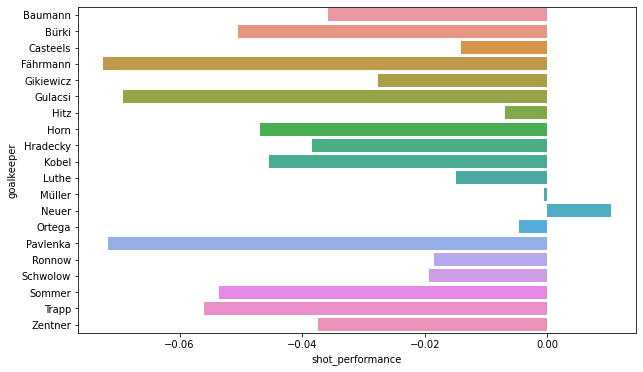

In [82]:
fig = plt.figure(figsize=(10,6))

sns.barplot(y='goalkeeper', x='shot_performance', data=xs_bundesliga, orient='h')
plt.show()

## Ligue 1

In [67]:
ligue1 = df[df.comp == 'Ligue 1']

In [85]:
xs_ligue1_2120 = ligue1.groupby('goalkeeper').agg({'saves': 'sum', 'psxs': 'sum', 'shots_faced': 'sum', 'psxg': 'sum', 'ga': 'sum', 'pksv': 'sum', 'sota': 'sum'}).reset_index()
xs_ligue1_2120['psxs_perc'] = xs_ligue1_2120['psxs'] / xs_ligue1_2120['shots_faced']
xs_ligue1_2120['save_perc'] = xs_ligue1_2120['saves'] / xs_ligue1_2120['shots_faced']
xs_ligue1_2120['shot_performance'] = xs_ligue1_2120['save_perc'] - xs_ligue1_2120['psxs_perc']
print(xs_ligue1_2120)

    goalkeeper  saves   psxs  shots_faced  psxg    ga  pksv   sota  psxs_perc  \
0      Allagbe   35.0   44.6         66.0  21.4  30.0   1.0   64.0   0.675758   
1      Benitez  119.0  123.3        172.0  48.7  53.0   0.0  167.0   0.716860   
2   Bernardoni   82.0   90.9        141.0  50.1  58.0   1.0  134.0   0.644681   
3       Costil   98.0  109.3        156.0  46.7  57.0   1.0  148.0   0.700641   
4       Dreyer   33.0   37.5         58.0  20.5  25.0   0.0   51.0   0.646552   
5        Gomis   68.0   67.8        103.0  35.2  35.0   0.0   97.0   0.658252   
6    Kawashima   62.0   64.6         94.0  29.4  31.0   1.0   91.0   0.687234   
7       Lafont  113.0  117.8        170.0  52.2  55.0   2.0  158.0   0.692941   
8         Leca   89.0   94.8        141.0  46.2  51.0   1.0  128.0   0.672340   
9      Lecomte   39.0   46.7         66.0  19.3  27.0   0.0   62.0   0.707576   
10       Lopes   94.0   95.9        139.0  43.1  43.0   2.0  130.0   0.689928   
11     Maignan   86.0   84.1

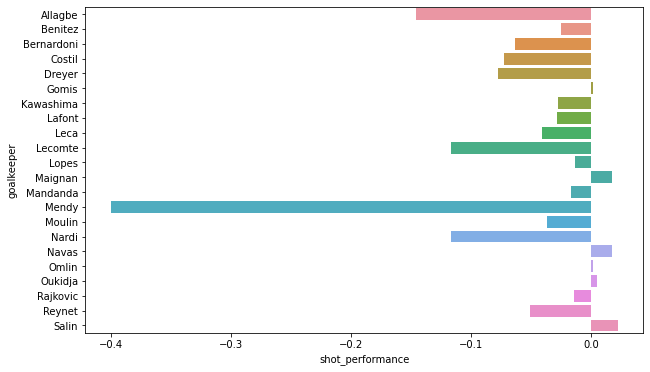

In [86]:
fig = plt.figure(figsize=(10,6))

sns.barplot(y='goalkeeper', x='shot_performance', data=xs_ligue1_2120, orient='h')
plt.show()

# Premier League

    goalkeeper  shot_performance
0      Alisson          0.043478
1       Areola          0.041975
2       Darlow         -0.055200
3        DeGea         -0.025556
4     Dubravka          0.009836
5      Ederson          0.001087
6    Fabianski         -0.008451
7       Guaita         -0.017647
8    Henderson          0.004000
9     Johnston         -0.002954
10        Leno         -0.008197
11    Martinez          0.030220
12    McCarthy         -0.062585
13       Mendy         -0.025926
14     Meslier          0.011765
15    Patricio         -0.050000
16        Pope          0.025828
17    Ramsdale         -0.006250
18        Ryan         -0.044444
19  Schmeichel         -0.010219


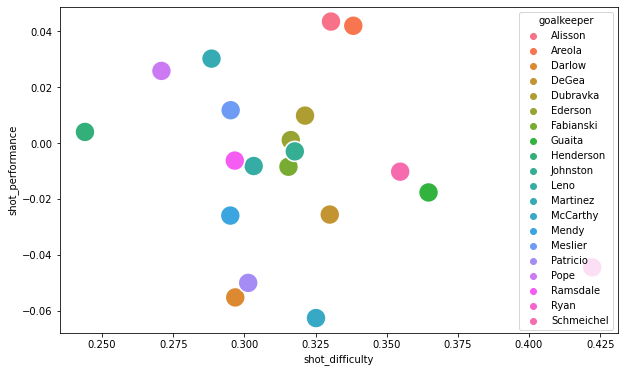

In [78]:
season = '20-21'
competition = 'Premier League'

pl = df[(df.comp == competition) & (df.season == season)]

xs_pl = pl.groupby('goalkeeper').agg({'saves': 'sum', 'psxs': 'sum', 'shots_faced': 'sum', 'psxg': 'sum', 'ga': 'sum', 'pksv': 'sum', 'sota': 'sum'}).reset_index()
xs_pl['save_perc'] = xs_pl['saves'] / xs_pl['shots_faced']
xs_pl['psxs_perc'] = xs_pl['psxs'] / xs_pl['shots_faced']
xs_pl['shot_performance'] = xs_pl['save_perc'] - xs_pl['psxs_perc']
xs_pl['shot_difficulty'] = xs_pl['psxg'] / xs_pl['shots_faced']

#print(xs_pl[['goalkeeper', 'psxs', 'shot_performance']])
print(xs_pl[['goalkeeper', 'shot_performance']])


fig = plt.figure(figsize=(10,6))

sns.scatterplot(x='shot_difficulty', y='shot_performance', s=400, data=xs_pl, hue='goalkeeper')

plt.show()

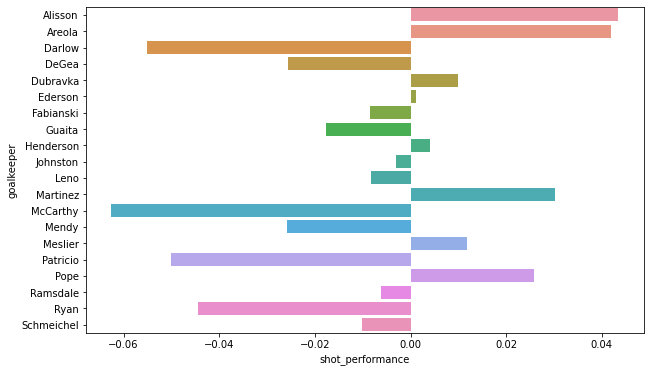

In [83]:
fig = plt.figure(figsize=(10,6))

sns.barplot(y='goalkeeper', x='shot_performance', data=xs_pl, orient='h')
plt.show()

## Swiss Goalkeepers

### Performance Season 2020 / 2021

In [71]:
swiss_gk_name = ['Sommer', 'Omlin', 'Bürki', 'Kobel', 'Hitz', 'Racioppi']
season = '20-21'

swiss_gk = df[df.goalkeeper.isin(swiss_gk_name) & (df.season == season)]

xs_swiss_gk = swiss_gk.groupby('goalkeeper').agg({'saves': 'sum', 'psxs': 'sum', 'shots_faced': 'sum', 'psxg': 'sum', 'ga': 'sum', 'pksv': 'sum', 'sota': 'sum'})
xs_swiss_gk['save_perc'] = xs_swiss_gk['saves'] / xs_swiss_gk['shots_faced']
xs_swiss_gk['psxs_perc'] = xs_swiss_gk['psxs'] / xs_swiss_gk['shots_faced']
xs_swiss_gk['shot_performance'] = xs_swiss_gk['save_perc'] - xs_swiss_gk['psxs_perc']
xs_swiss_gk['shot_difficulty'] = xs_swiss_gk['psxg'] / xs_swiss_gk['shots_faced']

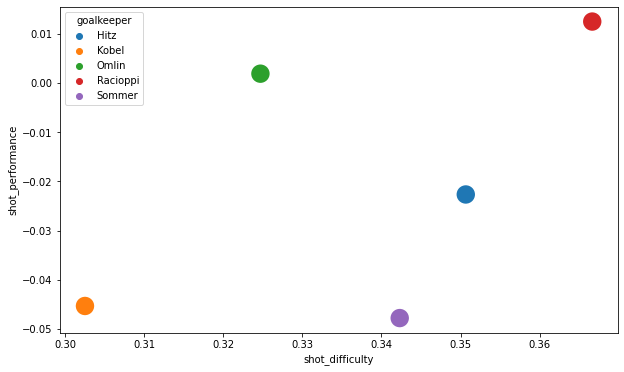

In [245]:
fig = plt.figure(figsize=(10,6))

sns.scatterplot(x='shot_difficulty', y='shot_performance', s=400, data=xs_swiss_gk, hue='goalkeeper')

plt.show()

In [77]:
print(xs_bundesliga.shot_performance.mean())
print(xs_bundesliga.psxg.mean())
print(xs_bundesliga.save_perc.mean())

print(xs_ligue1_2120.shot_performance.mean())
print(xs_ligue1_2120.psxg.mean())
print(xs_ligue1_2120.save_perc.mean())

print(xs_pl.shot_performance.mean())
print(xs_pl.psxg.mean())
print(xs_pl.save_perc.mean())

-0.03367686521651701
39.4
0.6512044636539798
-0.05368269493378994
36.24545454545454
0.6228077039680883
-0.00746195583106245
41.690000000000005
0.6761372741333672
